In [109]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [110]:

kddcup_columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent',
    'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root',
    'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
    'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
    'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label' 
]
#label is the target column

In [111]:
df = pd.read_csv('/Users/abhiramayla/Downloads/kddcup.data_10_percent_corrected.csv', header=None, names=kddcup_columns)
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [112]:
# Strip fullstops and spaces from the 'label' column
df['label'] = df['label'].str.strip(' .')


In [113]:
print("Data Head:")
print(df.head())

print("\nData Info:")
df.info()

print("\nLabel Distribution:")
print(df['label'].value_counts())

Data Head:
   duration protocol_type service flag  src_bytes  dst_bytes  land  \
0         0           tcp    http   SF        181       5450     0   
1         0           tcp    http   SF        239        486     0   
2         0           tcp    http   SF        235       1337     0   
3         0           tcp    http   SF        219       1337     0   
4         0           tcp    http   SF        217       2032     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                   9   
1               0       0    0  ...                  19   
2               0       0    0  ...                  29   
3               0       0    0  ...                  39   
4               0       0    0  ...                  49   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                     1.0                     0.0   
1                     1.0                     0.0   
2                     1.0                     0.0   
3

In [114]:
#--Data Preprocessing--#

In [115]:
# Handle duplicates in the dataset
print(f"\nOriginal samples: {df.shape[0]}")
df.drop_duplicates(inplace=True)
print(f"Samples after duplicate removal: {df.shape[0]}")

# Creating binary labels
df['is_attack'] = df['label'].apply(lambda x: 0 if x == 'normal' else 1)

print("\nBinary Label Distribution:")
print(df['is_attack'].value_counts())

# seperating into categorical and numerical features
categorical_features = ['protocol_type', 'service', 'flag']
numerical_features = [col for col in kddcup_columns if col not in categorical_features + ['label']]

# overall preprocessor for the full dataset 
preprocessor_full_data = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])




Original samples: 494021
Samples after duplicate removal: 145586

Binary Label Distribution:
is_attack
0    87832
1    57754
Name: count, dtype: int64


In [116]:
# Separate features into X and target y
X_full = df[numerical_features + categorical_features]
y_full = df['is_attack']


In [117]:
# --- Splitting Data into Training and Test Sets ---

In [120]:

X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

print(f"\nShape of X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}, y_test: {y_test.shape}")
print("\ny_train distribution:")
print(y_train.value_counts())
print("\ny_test distribution:")
print(y_test.value_counts())

#  for training only on normal samples for IF and AE

X_train_normal_filtered_if = X_train[y_train == 0]
X_train_normal_filtered_ae = X_train[y_train == 0]


Shape of X_train: (116468, 41), y_train: (116468,)
Shape of X_test: (29118, 41), y_test: (29118,)

y_train distribution:
is_attack
0    70265
1    46203
Name: count, dtype: int64

y_test distribution:
is_attack
0    17567
1    11551
Name: count, dtype: int64


In [121]:
# --- Preprocessing for Isolation Forest ---
preprocessor_if = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

print(f"\nFitting preprocessor for Isolation Forest on {X_train_normal_filtered_if.shape[0]} normal training samples")
X_train_processed_if = preprocessor_if.fit_transform(X_train_normal_filtered_if)
X_test_processed_if = preprocessor_if.transform(X_test)

print(f"Shape of processed training data (for IF): {X_train_processed_if.shape}")
print(f"Shape of processed test data (for IF): {X_test_processed_if.shape}")  



Fitting preprocessor for Isolation Forest on 70265 normal training samples
Shape of processed training data (for IF): (70265, 74)
Shape of processed test data (for IF): (29118, 74)


In [77]:
# --- Preprocessing for Autoencoder ---
preprocessor_ae = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

print(f"Fitting preprocessor for Autoencoder on {X_train_normal_filtered_ae.shape[0]} normal training samples...")
X_train_processed_ae = preprocessor_ae.fit_transform(X_train_normal_filtered_ae)
X_test_processed_ae = preprocessor_ae.transform(X_test)

print(f"Shape of processed training data (for AE): {X_train_processed_ae.shape}")
print(f"Shape of processed test data (for AE): {X_test_processed_ae.shape}")

Fitting preprocessor for Autoencoder on 70265 normal training samples...
Shape of processed training data (for AE): (70265, 74)
Shape of processed test data (for AE): (29118, 74)



--- Isolation Forest ---
Estimated contamination: 0.396701
Training Isolation Forest with contamination=0.39670123982553146
Predicting anomaly scores and labels for test data

Isolation Forest Evaluation:
Total test samples: 29118
True attacks in test set: 11551
Predicted attacks by IF: 18475

Classification Report (Isolation Forest):
              precision    recall  f1-score   support

      Normal       1.00      0.61      0.75     17567
      Attack       0.63      1.00      0.77     11551

    accuracy                           0.76     29118
   macro avg       0.81      0.80      0.76     29118
weighted avg       0.85      0.76      0.76     29118


Confusion Matrix (Isolation Forest):
[[10643  6924]
 [    0 11551]]

ROC AUC for Isolation Forest: 0.9920


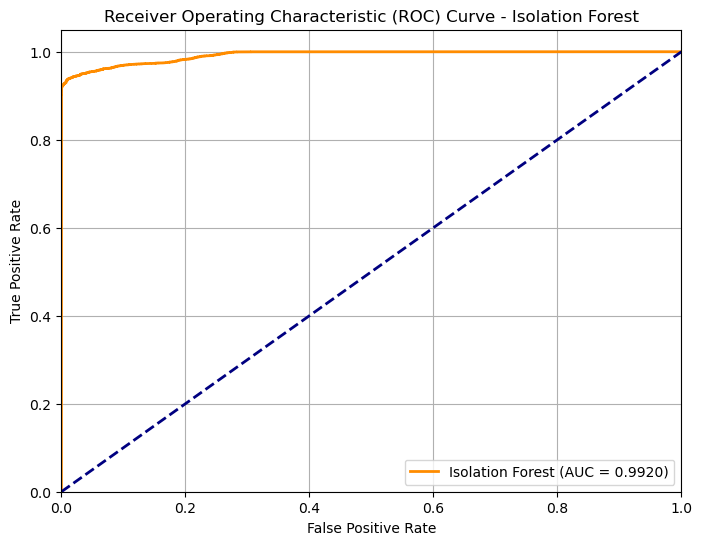

In [122]:
# --- Isolation Forest Implementation ---
print("\n--- Isolation Forest ---")

contamination_estimate = y_train.mean()
print(f"Estimated contamination: {contamination_estimate:4f}")

model = IsolationForest(
    n_estimators=100,
    max_samples='auto',
    contamination=contamination_estimate,
    random_state=42,
    n_jobs=-1
)

print(f"Training Isolation Forest with contamination={contamination_estimate}")
model.fit(X_train_processed_if)

print("Predicting anomaly scores and labels for test data")
test_scores_if = model.decision_function(X_test_processed_if)
test_preds_if_binary = model.predict(X_test_processed_if)

test_preds_if = np.where(test_preds_if_binary == -1, 1, 0)

print("\nIsolation Forest Evaluation:")
print(f"Total test samples: {len(y_test)}")
print(f"True attacks in test set: {np.sum(y_test == 1)}")
print(f"Predicted attacks by IF: {np.sum(test_preds_if == 1)}")

print("\nClassification Report (Isolation Forest):")
if_clf_report = classification_report(y_test, test_preds_if, target_names=['Normal', 'Attack'], output_dict=True, zero_division=0)
print(classification_report(y_test, test_preds_if, target_names=['Normal', 'Attack'], zero_division=0))

print("\nConfusion Matrix (Isolation Forest):")
cm_if = confusion_matrix(y_test, test_preds_if)
print(cm_if)


roc_auc_if = roc_auc_score(y_test, -test_scores_if)
print(f"\nROC AUC for Isolation Forest: {roc_auc_if:.4f}")

fpr_if, tpr_if, _ = roc_curve(y_test, -test_scores_if)
plt.figure(figsize=(8, 6))
plt.plot(fpr_if, tpr_if, color='darkorange', lw=2, label=f'Isolation Forest (AUC = {roc_auc_if:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Isolation Forest')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()  




--- Autoencoder ---
Autoencoder Input Dim: 74, Latent Dim: 9


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 74)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 37)             │         2,775 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 9)              │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 37)             │           370 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 74)             │         2,812 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,299 (24.61 KB)

 Trainable params: 6,299 (24.61 KB)

 Non-trainable params: 0 (0.00 B)


Training Autoencoder on normal data


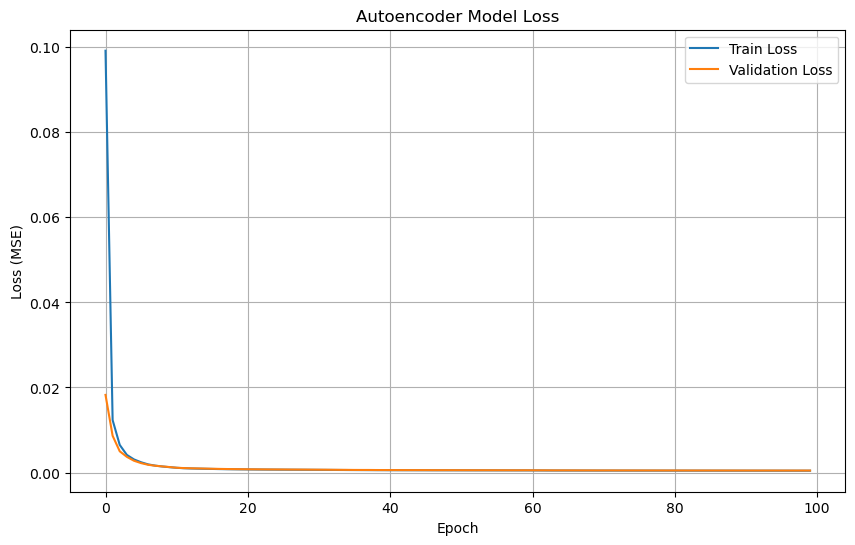


Calculating reconstruction errors for test data
910/910 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 1s 241us/step


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


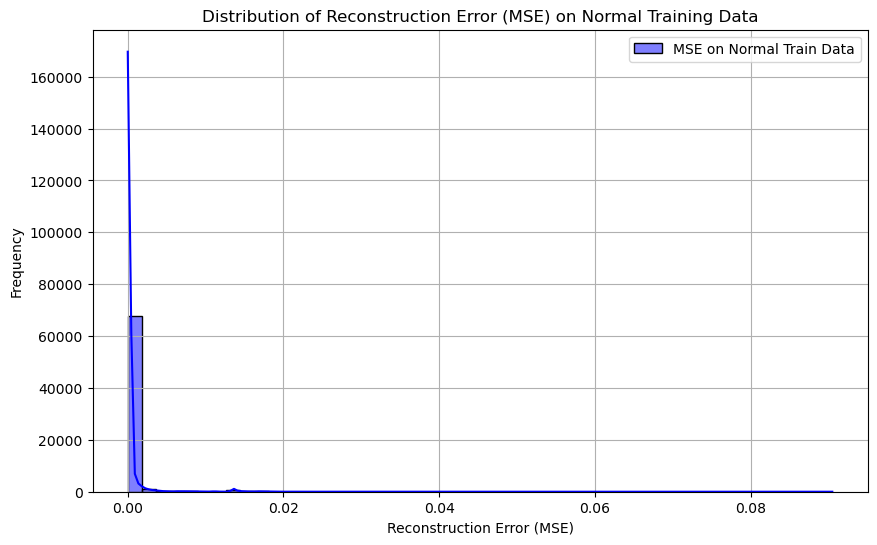

Autoencoder Anomaly Threshold (98th percentile of normal train MSE): 0.004485862308803597

Autoencoder Evaluation:
Total test samples: 29118
True attacks in test set: 11551
Predicted attacks by AE: 11563

Classification Report :
              precision    recall  f1-score   support

      Normal       0.98      0.98      0.98     17567
      Attack       0.97      0.97      0.97     11551

    accuracy                           0.98     29118
   macro avg       0.98      0.98      0.98     29118
weighted avg       0.98      0.98      0.98     29118


Confusion Matrix :
[[17219   348]
 [  336 11215]]

ROC AUC for Autoencoder: 0.9968133874549933


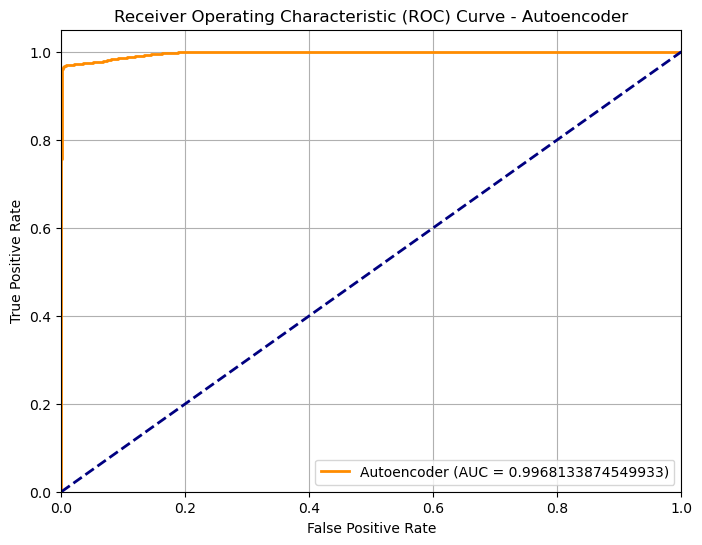

In [124]:
# --- Autoencoder Implementation ---
print("\n--- Autoencoder ---")

input_dim = X_train_processed_ae.shape[1]
encoding_dim = int(input_dim / 2)
latent_dim = int(encoding_dim / 4)

print(f"Autoencoder Input Dim: {input_dim}, Latent Dim: {latent_dim}")

input_layer = Input(shape=(input_dim,))

# Encoder
encoder_h1 = Dense(encoding_dim, activation="relu")(input_layer)
encoder_h2 = Dense(latent_dim, activation="relu")(encoder_h1)

# Decoder
decoder_h1 = Dense(encoding_dim, activation="relu")(encoder_h2)
output_layer = Dense(input_dim, activation='sigmoid')(decoder_h1) 

autoencoder = Model(inputs=input_layer, outputs=output_layer)

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

print("\nTraining Autoencoder on normal data")
history_ae = autoencoder.fit(
    X_train_processed_ae, X_train_processed_ae,
    epochs=100,
    batch_size=512,
    shuffle=True,
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
    verbose=0
)

plt.figure(figsize=(10, 6))
plt.plot(history_ae.history['loss'], label='Train Loss')
plt.plot(history_ae.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Model Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

print("\nCalculating reconstruction errors for test data")
reconstructions = autoencoder.predict(X_test_processed_ae)
mse_ae = np.mean(np.power(X_test_processed_ae - reconstructions, 2), axis=1)

train_reconstructions = autoencoder.predict(X_train_processed_ae)
train_mse_ae = np.mean(np.power(X_train_processed_ae - train_reconstructions, 2), axis=1)


plt.figure(figsize=(10, 6))
sns.histplot(train_mse_ae, bins=50, kde=True, color='blue', label='MSE on Normal Train Data')
plt.title('Distribution of Reconstruction Error (MSE) on Normal Training Data')
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

threshold_ae = np.percentile(train_mse_ae, 98)
print(f"Autoencoder Anomaly Threshold (98th percentile of normal train MSE): {threshold_ae}")

test_preds_ae = (mse_ae > threshold_ae).astype(int)

print("\nAutoencoder Evaluation:")
print(f"Total test samples: {len(y_test)}")
print(f"True attacks in test set: {np.sum(y_test == 1)}")
print(f"Predicted attacks by AE: {np.sum(test_preds_ae == 1)}")

print("\nClassification Report :")
ae_clf_report = classification_report(y_test, test_preds_ae, target_names=['Normal', 'Attack'], output_dict=True, zero_division=0)
print(classification_report(y_test, test_preds_ae, target_names=['Normal', 'Attack'], zero_division=0))

print("\nConfusion Matrix :")
cm_ae = confusion_matrix(y_test, test_preds_ae)
print(cm_ae)

roc_auc_ae = roc_auc_score(y_test, mse_ae)
print(f"\nROC AUC for Autoencoder: {roc_auc_ae}")
fpr_ae, tpr_ae, _ = roc_curve(y_test, mse_ae)
plt.figure(figsize=(8, 6))
plt.plot(fpr_ae, tpr_ae, color='darkorange', lw=2, label=f'Autoencoder (AUC = {roc_auc_ae})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Autoencoder')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



In [126]:
# --- Summary Comparison ---
print("\n--- Model Performance Summary ---")
print("Isolation Forest - F1-score (Attack):", if_clf_report['Attack']['f1-score'])
print("Autoencoder - F1-score (Attack):", ae_clf_report['Attack']['f1-score'])


--- Model Performance Summary ---
Isolation Forest - F1-score (Attack): 0.7693998534603345
Autoencoder - F1-score (Attack): 0.9704075452106948


In [ ]:
# --- Load and Preprocess Test Data (corrected.csv) ---

In [91]:
test_df_corrected = pd.read_csv('/Users/abhiramayla/Downloads/corrected.csv', header=None, names=kddcup_columns)


In [92]:
test_df_corrected['label'] = test_df_corrected['label'].str.strip(' .')


In [127]:
print("\nCorrected.csv Data Head:")
print(test_df_corrected.head())
print("\nCorrected.csv Label Distribution:")
print(test_df_corrected['label'].value_counts())


Corrected.csv Data Head:
   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           udp   private   SF        105        146     0   
3         0           udp   private   SF        105        146     0   
4         0           udp   private   SF        105        146     0   
5         0           udp   private   SF        105        146     0   
6         0           udp  domain_u   SF         29          0     0   

   wrong_fragment  urgent  hot  ...  dst_host_same_srv_rate  \
0               0       0    0  ...                     1.0   
3               0       0    0  ...                     1.0   
4               0       0    0  ...                     1.0   
5               0       0    0  ...                     1.0   
6               0       0    0  ...                     0.3   

   dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
0                    0.01                         0.00   
3                    0.01                     

In [128]:
#-- Preprocessing the same way as the training data --#

print(f"\nOriginal test samples (corrected.csv): {test_df_corrected.shape[0]}")
test_df_corrected.drop_duplicates(inplace=True)
print(f"Test samples after duplicate removal (corrected.csv): {test_df_corrected.shape[0]}")


test_df_corrected['is_attack'] = test_df_corrected['label'].apply(lambda x: 0 if x == 'normal' else 1)

X_test_corrected_full = test_df_corrected[numerical_features + categorical_features]
y_test_corrected_full = test_df_corrected['is_attack']

print("\nApplying fitted preprocessors to corrected.csv test data")
X_test_processed_if_corrected = preprocessor_if.transform(X_test_corrected_full)
X_test_processed_ae_corrected = preprocessor_ae.transform(X_test_corrected_full)

print(f"Shape of processed corrected.csv data (for IF): {X_test_processed_if_corrected.shape}")
print(f"Shape of processed corrected.csv data (for AE): {X_test_processed_ae_corrected.shape}")



Original test samples (corrected.csv): 77291
Test samples after duplicate removal (corrected.csv): 77291

Applying fitted preprocessors to corrected.csv test data
Shape of processed corrected.csv data (for IF): (77291, 74)
Shape of processed corrected.csv data (for AE): (77291, 74)


In [ ]:
# Evaluate Isolation Forest on corrected.csv ---


--- Evaluating Isolation Forest on corrected.csv ---

Isolation Forest Evaluation on corrected.csv:
Total test samples: 77291
True attacks in test set: 29378
Predicted attacks by IF: 39061

Classification Report (Isolation Forest - corrected.csv):
              precision    recall  f1-score   support

      Normal       0.99      0.79      0.87     47913
      Attack       0.74      0.98      0.84     29378

    accuracy                           0.86     77291
   macro avg       0.86      0.88      0.86     77291
weighted avg       0.89      0.86      0.86     77291


Confusion Matrix (Isolation Forest - corrected.csv):
[[37672 10241]
 [  558 28820]]

ROC AUC for Isolation Forest (corrected.csv): 0.9836748195218136


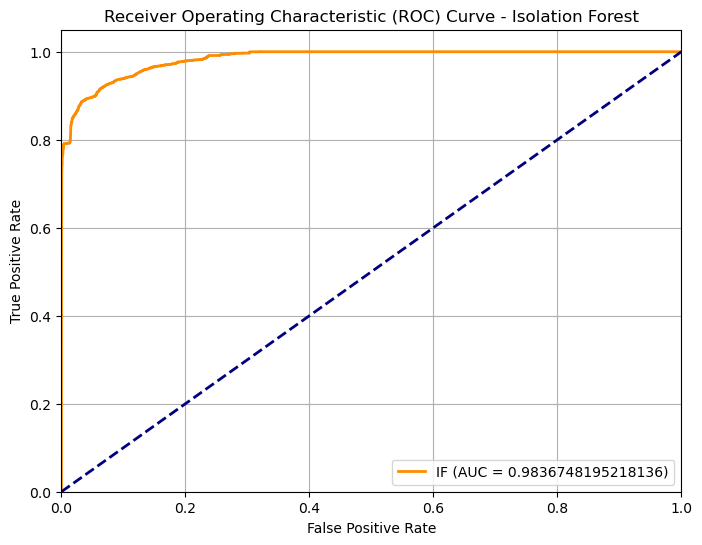

In [129]:
print("\n--- Evaluating Isolation Forest on corrected.csv ---")

test_scores_if_corrected = model.decision_function(X_test_processed_if_corrected)
test_preds_if_binary_corrected = model.predict(X_test_processed_if_corrected)
test_preds_if_corrected = np.where(test_preds_if_binary_corrected == -1, 1, 0)

print("\nIsolation Forest Evaluation on corrected.csv:")
print(f"Total test samples: {len(y_test_corrected_full)}")
print(f"True attacks in test set: {np.sum(y_test_corrected_full == 1)}")
print(f"Predicted attacks by IF: {np.sum(test_preds_if_corrected == 1)}")

print("\nClassification Report (Isolation Forest - corrected.csv):")
if_clf_report_corrected = classification_report(
    y_test_corrected_full,
    test_preds_if_corrected,
    target_names=['Normal', 'Attack'],
    output_dict=True,
    zero_division=0
)
print(classification_report(
    y_test_corrected_full,
    test_preds_if_corrected,
    target_names=['Normal', 'Attack'],
    zero_division=0
))

print("\nConfusion Matrix (Isolation Forest - corrected.csv):")
cm_if_corrected = confusion_matrix(y_test_corrected_full, test_preds_if_corrected)
print(cm_if_corrected)

roc_auc_if_corrected = roc_auc_score(y_test_corrected_full, -test_scores_if_corrected)
print(f"\nROC AUC for Isolation Forest (corrected.csv): {roc_auc_if_corrected}")

fpr_if_corrected, tpr_if_corrected, _ = roc_curve(y_test_corrected_full, -test_scores_if_corrected)
plt.figure(figsize=(8, 6))
plt.plot(fpr_if_corrected, tpr_if_corrected, color='darkorange', lw=2,
         label=f'IF (AUC = {roc_auc_if_corrected})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Isolation Forest')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



--- Evaluating Autoencoder on corrected.csv ---
2416/2416 ━━━━━━━━━━━━━━━━━━━━ 1s 381us/step

Autoencoder Evaluation on corrected.csv:
Total test samples: 77291
True attacks in test set: 29378
Predicted attacks by AE: 29233

Classification Report (Autoencoder - corrected.csv):
              precision    recall  f1-score   support

      Normal       0.97      0.97      0.97     47913
      Attack       0.95      0.94      0.95     29378

    accuracy                           0.96     77291
   macro avg       0.96      0.96      0.96     77291
weighted avg       0.96      0.96      0.96     77291


Confusion Matrix (Autoencoder - corrected.csv):
[[46423  1490]
 [ 1635 27743]]

ROC AUC for Autoencoder (corrected.csv): 0.9882


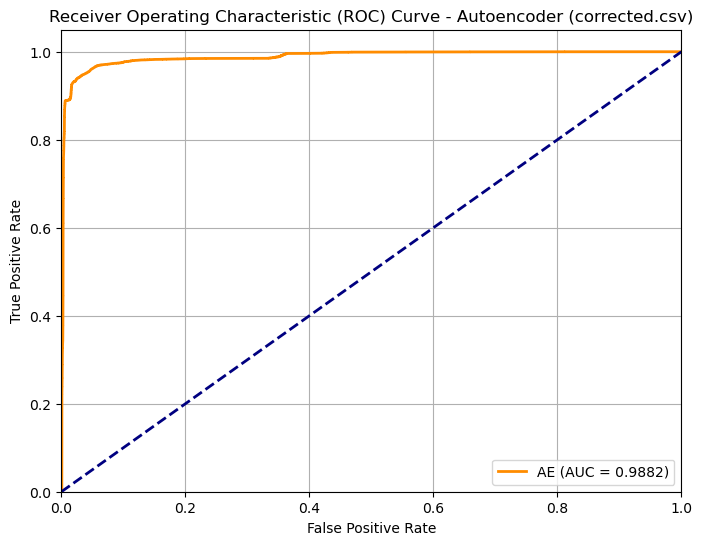

In [ ]:
#  Evaluate Autoencoder on corrected.csv ---
print("\n--- Evaluating Autoencoder on corrected.csv ---")

reconstructions_ae_corrected = autoencoder.predict(X_test_processed_ae_corrected)
mse_ae_corrected = np.mean(np.power(X_test_processed_ae_corrected - reconstructions_ae_corrected, 2), axis=1)

test_preds_ae_corrected = (mse_ae_corrected > threshold_ae).astype(int)

print("\nAutoencoder Evaluation on corrected.csv:")
print(f"Total test samples: {len(y_test_corrected_full)}")
print(f"True attacks in test set: {np.sum(y_test_corrected_full == 1)}")
print(f"Predicted attacks by AE: {np.sum(test_preds_ae_corrected == 1)}")

print("\nClassification Report (Autoencoder - corrected.csv):")
ae_clf_report_corrected = classification_report(y_test_corrected_full, test_preds_ae_corrected, target_names=['Normal', 'Attack'], output_dict=True, zero_division=0)
print(classification_report(y_test_corrected_full, test_preds_ae_corrected, target_names=['Normal', 'Attack'], zero_division=0))

print("\nConfusion Matrix (Autoencoder - corrected.csv):")
cm_ae_corrected = confusion_matrix(y_test_corrected_full, test_preds_ae_corrected)
print(cm_ae_corrected)


roc_auc_ae_corrected = roc_auc_score(y_test_corrected_full, mse_ae_corrected)
print(f"\nROC AUC for Autoencoder (corrected.csv): {roc_auc_ae_corrected:.4f}")
fpr_ae_corrected, tpr_ae_corrected, _ = roc_curve(y_test_corrected_full, mse_ae_corrected)

plt.figure(figsize=(8, 6))
plt.plot(fpr_ae_corrected, tpr_ae_corrected, color='darkorange', lw=2, label=f'AE (AUC = {roc_auc_ae_corrected:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Autoencoder (corrected.csv)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



In [130]:

print("\n--- Model Performance Summary on corrected.csv ---")
print("Isolation Forest - F1-score (Attack):", if_clf_report_corrected['Attack']['f1-score'])
print("Autoencoder - F1-score (Attack):", ae_clf_report_corrected['Attack']['f1-score'])



--- Model Performance Summary on corrected.csv ---
Isolation Forest - F1-score (Attack): 0.8422098511082863
Autoencoder - F1-score (Attack): 0.9466823633788879


In [ ]:
# --- Load and Preprocess Unlabeled Test Data (kddcup.testdata.unlabeled_10_percent.csv) ---

In [132]:

kddcup_unlabeled_columns = kddcup_columns[:-1] # All columns except the last one ('label')



In [133]:
unlabeled_df = pd.read_csv('/Users/abhiramayla/Downloads/kddcup.testdata.unlabeled_10_percent.csv', header=None, names=kddcup_unlabeled_columns)
unlabeled_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,udp,private,SF,105,146,0,0,0,0,...,255,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0
1,0,udp,private,SF,105,146,0,0,0,0,...,255,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0
2,0,udp,private,SF,105,146,0,0,0,0,...,255,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0
3,0,udp,private,SF,105,146,0,0,0,0,...,255,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0
4,0,udp,private,SF,105,146,0,0,0,0,...,255,254,1.0,0.01,0.01,0.0,0.0,0.0,0.0,0.0


In [134]:
print(f"\nShape of unlabeled data: {unlabeled_df.shape}")


Shape of unlabeled data: (311029, 41)


In [135]:
# Handling duplicates in the unlabeled test set
print(f"Original unlabeled samples: {unlabeled_df.shape[0]}")
unlabeled_df.drop_duplicates(inplace=True)
print(f"Unlabeled samples after duplicate removal: {unlabeled_df.shape[0]}")


Original unlabeled samples: 311029
Unlabeled samples after duplicate removal: 77216


In [136]:

print("\nApplying fitted preprocessors to unlabeled test data...")
X_unlabeled_processed_if = preprocessor_if.transform(unlabeled_df[numerical_features + categorical_features])
X_unlabeled_processed_ae = preprocessor_ae.transform(unlabeled_df[numerical_features + categorical_features])

print(f"Shape of processed unlabeled data (for IF): {X_unlabeled_processed_if.shape}")
print(f"Shape of processed unlabeled data (for AE): {X_unlabeled_processed_ae.shape}")



Applying fitted preprocessors to unlabeled test data...
Shape of processed unlabeled data (for IF): (77216, 74)
Shape of processed unlabeled data (for AE): (77216, 74)


In [137]:
# --Generate Predictions ---

# Predictions for Isolation Forest
test_preds_if_binary_unlabeled = model.predict(X_unlabeled_processed_if)

unlabeled_df['predicted_anomaly_if'] = np.where(test_preds_if_binary_unlabeled == -1, 1, 0)

# Predictions for Autoencoder
reconstructions_ae_unlabeled = autoencoder.predict(X_unlabeled_processed_ae, verbose=0)
mse_ae_unlabeled = np.mean(np.power(X_unlabeled_processed_ae - reconstructions_ae_unlabeled, 2), axis=1)
unlabeled_df['predicted_anomaly_ae'] = (mse_ae_unlabeled > threshold_ae).astype(int)

print("\nSample of Unlabeled Data with Predictions:")
print(unlabeled_df.head())
print(f"\nTotal samples predicted: {unlabeled_df.shape[0]}")
print(f"Isolation Forest predicted anomalies: {unlabeled_df['predicted_anomaly_if'].sum()}")
print(f"Autoencoder predicted anomalies: {unlabeled_df['predicted_anomaly_ae'].sum()}")


Sample of Unlabeled Data with Predictions:
   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           udp   private   SF        105        146     0   
3         0           udp   private   SF        105        146     0   
4         0           udp   private   SF        105        146     0   
5         0           udp   private   SF        105        146     0   
6         0           udp  domain_u   SF         29          0     0   

   wrong_fragment  urgent  hot  ...  dst_host_same_srv_rate  \
0               0       0    0  ...                     1.0   
3               0       0    0  ...                     1.0   
4               0       0    0  ...                     1.0   
5               0       0    0  ...                     1.0   
6               0       0    0  ...                     0.3   

   dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
0                    0.01                         0.00   
3                    0.01   

In [108]:
# -- Save to CSV ---
output_filename = 'kddcup_unlabeled_with_predictions.csv'
unlabeled_df.to_csv(output_filename, index=False)

print(f"Saved the  unlabeled data with anomaly predictions to '{output_filename}'.")


Saved the  unlabeled data with anomaly predictions to 'kddcup_unlabeled_with_predictions.csv'.
